In [ ]:
import sys
sys.path.insert(0,"../")

In [ ]:
import numpy as np
import pandas as pd
import os 
import torch
import random


In [ ]:
import pickle

In [ ]:
import collections, os, io
from PIL import Image
import torch
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset
import random
import pickle
import core.utils_data as utils_disco
import core.utils_vox as utils_vox
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import cv2
from matplotlib import cm
import matplotlib
from itertools import combinations

import ipdb 
st = ipdb.set_trace

In [ ]:
def draw_corners_on_image(rgb, corners_cam, scores, tids, pix_T_cam,info_text=None):
    # first we need to get rid of invalid gt boxes
    # gt_boxes = trim_gt_boxes(gt_boxes)
    B, C, H, W = list(rgb.shape)
    assert(C==3)
    B2, N, D, E = list(corners_cam.shape)
    assert(B2==B)
    assert(D==8) # 8 corners
    assert(E==3) # 3D

    #rgb = back2color(rgb)
    corners_cam_ = torch.reshape(corners_cam, [B, N*8, 3])
    corners_pix_ = utils_disco.apply_pix_T_cam(pix_T_cam, corners_cam_)
    corners_pix = torch.reshape(corners_pix_, [B, N, 8, 2])
    out = draw_boxes_on_image_py(rgb[0].cpu().numpy(),
                                      corners_pix[0].cpu().numpy(),
                                      scores[0].cpu().numpy(),
                                      tids[0].cpu().numpy(),info_text)
    out = torch.from_numpy(out).type(torch.ByteTensor).permute(2, 0, 1)
    out = torch.unsqueeze(out, dim=0)
    #out = preprocess_color(out)
    out = torch.reshape(out, [1, C, H, W])
    return out, corners_pix

def draw_boxes_on_image_py(rgb, corners_pix, scores, tids,info_text=None, boxes=None, thickness=1,text=False):
    # all inputs are numpy tensors
    # rgb is H x W x 3
    # corners_pix is N x 8 x 2, in xy order
    # scores is N
    # tids is N
    # boxes is N x 9 < this is only here to print some rotation info
    # pix_T_cam is 4 x 4
    rgb = np.transpose(rgb, [1, 2, 0]) # put channels last
    rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    H, W, C = rgb.shape
    assert(C==3)
    N, D, E = corners_pix.shape
    assert(D==8)
    assert(E==2)

    if boxes is not None:
        rx = boxes[:,6]
        ry = boxes[:,7]
        rz = boxes[:,8]
    else:
        rx = 0
        ry = 0
        rz = 0

    color_map = matplotlib.cm.get_cmap('tab20')
    color_map = color_map.colors

    # draw
    for ind, corners in enumerate(corners_pix):
        # corners is 8 x 2
        # st()
        if not np.isclose(scores[ind], 0.0):
            # print 'score = %.2f' % scores[ind]
            color_id = tids[ind] % 20
            color = color_map[2]
            color_text = color_map[2]

            # st()

            color = np.array(color)*255.0
            # print 'tid = %d; score = %.3f' % (tids[ind], scores[ind])
            if info_text is not None:
                text_to_put = info_text[ind]
                cv2.putText(rgb,
                            text_to_put, 
                            (np.min(corners[:,0]), np.min(corners[:,1])),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, # font size
                            color_text,
                            2) # font weight

            for c in corners:

                # rgb[pt1[0], pt1[1], :] = 255
                # rgb[pt2[0], pt2[1], :] = 255
                # rgb[np.clip(int(c[0]), 0, W), int(c[1]), :] = 255

                c0 = np.clip(int(c[0]), 0,  W-1)
                c1 = np.clip(int(c[1]), 0,  H-1)
                rgb[c1, c0, :] = 255

            # we want to distinguish between in-plane edges and out-of-plane ones
            # so let's recall how the corners are ordered:
            xs = np.array([-1/2., -1/2., -1/2., -1/2., 1/2., 1/2., 1/2., 1/2.])
            ys = np.array([-1/2., -1/2., 1/2., 1/2., -1/2., -1/2., 1/2., 1/2.])
            zs = np.array([-1/2., 1/2., -1/2., 1/2., -1/2., 1/2., -1/2., 1/2.])
            xs = np.reshape(xs, [8, 1])
            ys = np.reshape(ys, [8, 1])
            zs = np.reshape(zs, [8, 1])
            offsets = np.concatenate([xs, ys, zs], axis=1)

            corner_inds = list(range(8))
            combos = list(combinations(corner_inds, 2))

            for combo in combos:
                pt1 = offsets[combo[0]]
                pt2 = offsets[combo[1]]
                # draw this if it is an in-plane edge
                eqs = pt1==pt2
                if np.sum(eqs)==2:
                    i, j = combo
                    pt1 = (corners[i, 0], corners[i, 1])
                    pt2 = (corners[j, 0], corners[j, 1])
                    retval, pt1, pt2 = cv2.clipLine((0, 0, W, H), pt1, pt2)
                    if retval:
                        cv2.line(rgb, pt1, pt2, color, thickness, cv2.LINE_AA)

                    # rgb[pt1[0], pt1[1], :] = 255
                    # rgb[pt2[0], pt2[1], :] = 255
    rgb = cv2.cvtColor(rgb.astype(np.uint8), cv2.COLOR_BGR2RGB)
    # utils_basic.print_stats_py('rgb_uint8', rgb)
    # imageio.imwrite('boxes_rgb.png', rgb)
    return rgb

def summ_box_by_corners(rgbR, corners, scores, tids, pix_T_cam, only_return=False):
    # rgb is B x H x W x C
    # corners is B x N x 8 x 3 
    # scores is B x N
    # tids is B x N
    # pix_T_cam is B x 4 x 4
    # st()
    B, C, H, W = list(rgbR.shape)
    boxes_vis = draw_corners_on_image(rgbR,corners,scores,tids,pix_T_cam,None)
    return boxes_vis

In [ ]:
def collate_boxes(data):
    query_image, num_boxes_q, boxes_q, boxes_viz_q, key_image, num_boxes_k, boxes_k, boxes_viz_k, scene_num, query_img_view, key_img_view, pix_T_cams_raw, camR_T_origin_raw, origin_T_camXs_raw, gt_egomotion, idx, scene_path = zip(*data)
    batch_size = len(num_boxes_q)
    
#     print(boxes_viz_q)
#     print(query_image.shape, num_boxes_q.shape, boxes_q.shape, boxes_viz_q.shape)
#     print(scene_num.shape, query_img_view.shape, key_img_view.shape, pix_T_cams_raw.shape, camR_T_origin_raw.shape, origin_T_camXs_raw.shape, gt_egomotion.shape, idx.shape)
    
#     print(torch.stack(list(query_image)))
    query_image = torch.stack(list(query_image))
    key_image = torch.stack(list(key_image))
    
 
    num_boxes_q = torch.as_tensor(list(num_boxes_q))
    num_boxes_k = torch.as_tensor(list(num_boxes_k))
    
    boxes_q = list(boxes_q)
    boxes_k = list(boxes_k)
    
    boxes_viz_q = torch.stack(list(boxes_viz_q))
    boxes_viz_k = torch.stack(list(boxes_viz_k))
 
    object_boxes_q = torch.cat(boxes_q, dim=0)
    object_boxes_k = torch.cat(boxes_k, dim=0)
    
    scene_num = torch.as_tensor(list(scene_num))
    query_img_view = torch.as_tensor(list(query_img_view))
    index = torch.as_tensor(list(idx))
    scene_path = list(scene_path)
    key_img_view = torch.as_tensor(list(key_img_view))
    pix_T_cams_raw = torch.stack(list(pix_T_cams_raw), dim=0)
    camR_T_origin_raw = torch.stack(list(camR_T_origin_raw), dim=0)
    origin_T_camXs_raw = torch.stack(list(origin_T_camXs_raw), dim=0)
    gt_egomotion = torch.stack(list(gt_egomotion), dim=0)
    
    
    metadata = {"index": index, "scene_number":scene_num, "query_image_index":query_img_view,"key_image_index":key_img_view, "pix_T_cams_raw":torch.as_tensor(pix_T_cams_raw).cuda(), "camR_T_origin_raw":torch.as_tensor(camR_T_origin_raw).cuda(), "origin_T_camXs_raw":torch.as_tensor(origin_T_camXs_raw).cuda(), "rel_viewpoint":torch.as_tensor(gt_egomotion).cuda(), "scene_path": scene_path}
    feed_dict_q = {"images":torch.as_tensor(query_image).cuda(), "objects":num_boxes_q, "objects_boxes":torch.as_tensor(object_boxes_q).cuda(), "images_with_boxes":torch.as_tensor(boxes_viz_q).cuda()}
    feed_dict_k = {"images":torch.as_tensor(key_image).cuda(), "objects":num_boxes_k, "objects_boxes":torch.as_tensor(object_boxes_k).cuda(), "images_with_boxes":torch.as_tensor(boxes_viz_k).cuda()}
    
    
    return feed_dict_q, feed_dict_k, metadata

In [ ]:
class CLEVR_train(Dataset):
	def __init__(self, root_dir, hyp_N=1, transform=None, target_transform=None, few_shot=False):
		self.root_dir = root_dir
		self.transform = transform
		self.target_transform = target_transform
		self.target_res = 256
		self.N = hyp_N
		self.few_shot = few_shot
		self.views = 18


		if root_dir.endswith("txt"):
			data  = []

			with open(root_dir) as f:
				lines = f.readlines()

				for line in lines:
					data.append(line.split()[0])

			self.all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]
		else:
			self.all_files = [os.path.join(root_dir,f) for f in os.listdir(root_dir) if f.endswith('.p')]
			
		self.all_files.sort()
			
		print('Initialised.....',len(self.all_files),' files...')
			
 
		self.do_shape = True
		self.do_color = False
		self.do_material = False
		self.do_style = False
		self.do_style_content = False

	def trees_rearrange(self, trees):
		updated_trees =[]
		all_bboxes = []
		all_scores = []
		all_classes_list = []
		for tree in trees:
			tree,boxes,_,all_classes = self.bbox_rearrange(tree,boxes=[],classes={},all_classes=[])
			if self.do_shape:
				classes = [class_val["shape"] for class_val  in all_classes]
			elif self.do_color:
				classes = [class_val["color"] for class_val  in all_classes]
			elif self.do_material:
				classes = [class_val["material"] for class_val  in all_classes]
			elif self.do_style:
				classes = [class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
			elif self.do_style_content:
				classes = [class_val["shape"]+"/"+class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
			elif self.do_color_content:            
				classes = [class_val["shape"]+"/"+class_val["color"] for class_val  in all_classes]
			elif self.do_material_content:            
				classes = [class_val["shape"]+"/"+ class_val["material"] for class_val  in all_classes]
			else:            
				classes = [class_val["shape"]+"/"+ class_val["color"] +"_"+class_val["material"] for class_val  in all_classes]
			boxes = np.stack(boxes)
			classes = np.stack(classes)
			n,_  = boxes.shape 
			assert n == len(classes)
			scores = np.pad(np.ones([n]),[0,self.N-n])
			boxes = np.pad(boxes,[[0,self.N-n],[0,0]])
			classes = np.pad(classes,[0,self.N-n])
			updated_trees.append(tree)
			all_classes_list.append(classes)
			all_scores.append(scores)
			all_bboxes.append(boxes)
		all_bboxes = np.stack(all_bboxes)
		all_scores = np.stack(all_scores)
		all_classes_list = np.stack(all_classes_list)
		return all_bboxes,all_scores,all_classes_list

	def bbox_rearrange(self, tree,boxes= [],classes={},all_classes=[]):
		for i in range(0, tree.num_children):
			updated_tree,boxes,classes,all_classes = self.bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
			tree.children[i] = updated_tree     
		if tree.function == "describe":
			xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
			box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
			tree.bbox_origin = box
			boxes.append(box)
			classes["shape"] = tree.word
			all_classes.append(classes)
			classes = {}
		if tree.function == "combine":
			if "large" in tree.word or "small" in tree.word:
				classes["size"] = tree.word
			elif "metal" in tree.word or "rubber" in tree.word:
				classes["material"] = tree.word
			else:
				classes["color"] = tree.word
		return tree,boxes,classes,all_classes

	def __len__(self):
		return len(self.all_files)

	def __getitem__(self, idx):
		
		hyp_B = 1
		hyp_S = 2
		hyp_N = self.N

		__p = lambda x: utils_disco.pack_seqdim(x, hyp_B)
		__u = lambda x: utils_disco.unpack_seqdim(x, hyp_B)
		__pb = lambda x: utils_disco.pack_boxdim(x, hyp_N)
		__ub = lambda x: utils_disco.unpack_boxdim(x, hyp_N)
		
		Z, Y, X = 144, 144, 144
		Z2, Y2, X2 = int(Z/2), int(Y/2), int(X/2)
		Z4, Y4, X4 = int(Z/4), int(Y/4), int(X/4)
		
		######## Get query and key index #########################
		
		scene_num = idx 
		query_idx, key_idx = random.sample(range(0, self.views), 2)
		index = scene_num*self.views + query_idx
		

		scene_path = self.all_files[scene_num]
		data = pickle.load(open(scene_path, "rb"))
		
		###### Take necessary matrices from data dict ############
		
		tids = torch.from_numpy(np.reshape(np.arange(hyp_B*hyp_N),[hyp_B,hyp_N]))
		pix_T_cams = torch.from_numpy(np.stack((data["pix_T_cams_raw"][query_idx],data["pix_T_cams_raw"][key_idx]))).reshape(hyp_B, hyp_S, 4, 4).cuda()
		
		camRs_T_origin = np.stack((data['camR_T_origin_raw'][query_idx],data['camR_T_origin_raw'][key_idx]))
		camRs_T_origin = torch.from_numpy(camRs_T_origin).reshape(hyp_B, hyp_S, 4, 4).cuda()
		
		origin_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_origin)))
		
		origin_T_camXs = torch.from_numpy(np.stack((data['origin_T_camXs_raw'][query_idx], data['origin_T_camXs_raw'][key_idx]))).reshape(hyp_B, hyp_S, 4, 4).cuda()
		camX0_T_camXs = utils_disco.get_camM_T_camXs(origin_T_camXs, ind=0)
		camRs_T_camXs = __u(torch.matmul(utils_disco.safe_inverse(__p(origin_T_camRs)), __p(origin_T_camXs))) 
		
		
		camXs_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_camXs)))
		camX0_T_camRs = camXs_T_camRs[:,0]
		camX1_T_camRs = camXs_T_camRs[:,1]
		
		camR_T_camX0  = utils_disco.safe_inverse(camX0_T_camRs)
										  
		rgb_camXs = data["rgb_camXs_raw"][:,:,:,:3]
		rgb_camX0 = torch.from_numpy(rgb_camXs[query_idx]).permute(2,0,1).reshape(hyp_B, 3, 256, 256) #torch.from_numpy(np.fliplr(rgb_camXs[0,0])).reshape(1, 256, 256, 3).permute(0,3,1,2)
		rgb_camX1 = torch.from_numpy(rgb_camXs[key_idx]).permute(2,0,1).reshape(hyp_B, 3, 256, 256)                                 
										  
		############ load tree file ##############################
		
		tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
		tree_path = tree_path.replace("datasets","dataset")
		tree_file = pickle.load(open(os.path.join(tree_path),"rb"))
										  
		gt_boxesR,scores,classes = self.trees_rearrange([tree_file])
		
		########### set up gt boxes #############################
										  
		gt_boxesR = torch.from_numpy(gt_boxesR).cuda().float() # torch.Size([2, 3, 6])
		gt_boxesR_end = torch.reshape(gt_boxesR,[hyp_B,hyp_N,2,3])
		gt_boxesR_theta = utils_disco.get_alignedboxes2thetaformat(gt_boxesR_end)
		gt_boxesR_corners = utils_disco.transform_boxes_to_corners(gt_boxesR_theta)
										  
		gt_boxesRMem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z2,Y2,X2))
		gt_boxesRMem_end = utils_disco.get_ends_of_corner(gt_boxesRMem_corners) 
		
		gt_boxesRMem_theta = utils_disco.transform_corners_to_boxes(gt_boxesRMem_corners)
		gt_boxesRUnp_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z,Y,X))
										  
		gt_boxesRUnp_end = utils_disco.get_ends_of_corner(gt_boxesRUnp_corners)
										  
		gt_boxesX0_corners = __ub(utils_disco.apply_4x4(camX0_T_camRs, __pb(gt_boxesR_corners)))
		gt_boxesX1_corners = __ub(utils_disco.apply_4x4(camX1_T_camRs, __pb(gt_boxesR_corners)))
										  
		gt_boxesXs_corners = __u(__ub(utils_disco.apply_4x4(__p(camXs_T_camRs), __p(__pb(gt_boxesR_corners).unsqueeze(1).repeat(1,hyp_S,1,1)) )))
		gt_boxesXs_end = __u(utils_disco.get_ends_of_corner(__p(gt_boxesXs_corners)))
										  
		gt_boxesX0Mem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesX0_corners),Z2,Y2,X2))
		gt_boxesX0Mem_theta = utils_disco.transform_corners_to_boxes(gt_boxesX0Mem_corners)
		gt_boxesX0Mem_end = utils_disco.get_ends_of_corner(gt_boxesX0Mem_corners)
		gt_boxesX0_end = utils_disco.get_ends_of_corner(gt_boxesX0_corners)  
										  
		gt_cornersX0_pix = __ub(utils_disco.apply_pix_T_cam(pix_T_cams[:,0], __pb(gt_boxesX0_corners)))
		gt_cornersX1_pix = __ub(utils_disco.apply_pix_T_cam(pix_T_cams[:,1], __pb(gt_boxesX1_corners)))
										  
		########### gt egomotion #############################################
		'''
		matmul(query_camX_T_origin, target_camX_T_origin.inverse())
		'''
		
		query_camX_T_origin = torch.from_numpy(data['origin_T_camXs_raw'][query_idx]).reshape(1,4,4)
		origin_T_camX_target = utils_disco.safe_inverse(torch.from_numpy(data['origin_T_camXs_raw'][key_idx]).reshape(1, 4, 4))
		viewpoints = torch.matmul(query_camX_T_origin, origin_T_camX_target)
		
		rx, ry, rz = utils_disco.rotm2eul(viewpoints)
		rx, ry, rz = rx.unsqueeze(1), ry.unsqueeze(1), rz.unsqueeze(1)
		xyz = viewpoints[:, :3, -1]


		view_vector = [xyz, torch.cos(rx), torch.sin(rx), torch.cos(rz), torch.sin(rz)]
		rel_viewpoint = torch.cat(view_vector, dim=-1)
										  
										  
		################# get bbobex on image    ##############################
		boxes_vis_q, corners_pix_q = summ_box_by_corners(rgb_camX0, gt_boxesX0_corners, torch.from_numpy(scores), tids, pix_T_cams[:, 0])
		boxes_vis_k, corners_pix_k = summ_box_by_corners(rgb_camX1, gt_boxesX1_corners, torch.from_numpy(scores), tids, pix_T_cams[:, 1])

		boxes_q = torch.zeros([hyp_N, 4])
		
		for n in range(hyp_N):
			boxes_q[n][0] = torch.min(corners_pix_q[0, n, :, 0]) 
			boxes_q[n][1] = torch.min(corners_pix_q[0, n, :, 1]) 
			boxes_q[n][2] = torch.max(corners_pix_q[0, n, :, 0]) 
			boxes_q[n][3] = torch.max(corners_pix_q[0, n, :, 1])
		
		boxes_k = torch.zeros([hyp_N, 4])
		
		for n in range(hyp_N):
			boxes_k[n][0] = torch.min(corners_pix_k[0, n, :, 0]) 
			boxes_k[n][1] = torch.min(corners_pix_k[0, n, :, 1]) 
			boxes_k[n][2] = torch.max(corners_pix_k[0, n, :, 0]) 
			boxes_k[n][3] = torch.max(corners_pix_k[0, n, :, 1])

            
		return (rgb_camX0/255.).squeeze(), hyp_N, boxes_q, boxes_vis_q.squeeze(), (rgb_camX1/255.).squeeze(), hyp_N, boxes_k, boxes_vis_k.squeeze(), scene_num, query_idx, key_idx, pix_T_cams.squeeze(), camRs_T_origin.squeeze(), origin_T_camXs.squeeze(), rel_viewpoint, index, scene_path


In [ ]:
train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)

Initialised..... 234  files...


In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_boxes)

In [ ]:
for b in train_loader:
    feed_dict_q, feed_dict_k, metadata = b
    break
    

../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [ ]:
metadata['scene_path']

['/home/mprabhud/dataset/clevr_lang/npys/ab_3/CLEVR_new_000059.p',
 '/home/mprabhud/dataset/clevr_lang/npys/ab_3/CLEVR_new_000016.p',
 '/home/mprabhud/dataset/clevr_lang/npys/ab_3/CLEVR_new_000050.p',
 '/home/mprabhud/dataset/clevr_lang/npys/ab_3/CLEVR_new_000044.p',
 '/home/mprabhud/dataset/clevr_lang/npys/ab_2/CLEVR_new_000083.p']

In [ ]:
metadata['scene_number'], metadata['key_image_index'], metadata['query_image_index'], metadata['index']

(tensor([230, 187, 221, 215, 169]),
 tensor([ 0,  4, 16, 12, 13]),
 tensor([ 3, 13,  5, 17, 17]),
 tensor([4143, 3379, 3983, 3887, 3059]))

In [ ]:
feed_dict_q['images_with_boxes'].size()

torch.Size([5, 3, 256, 256])

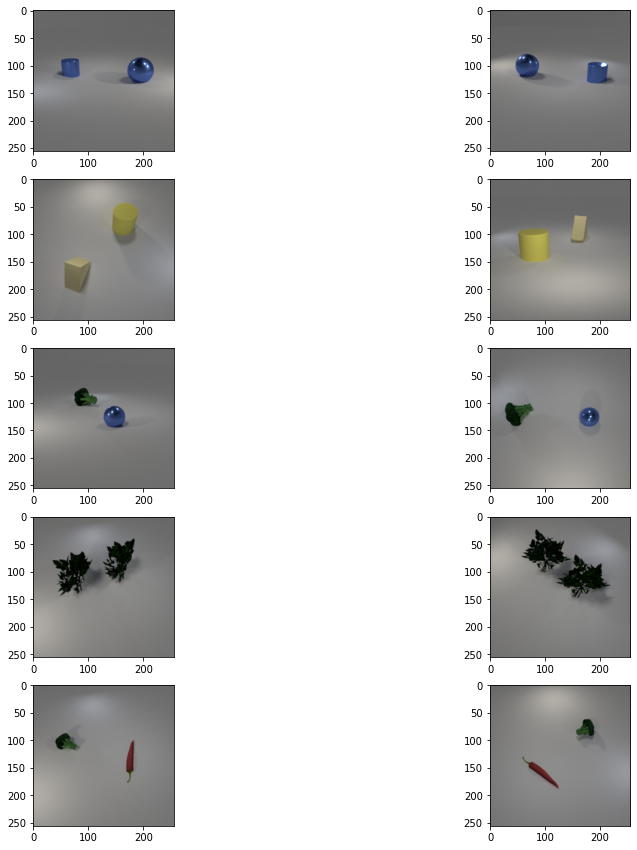

In [ ]:
f, axarr = plt.subplots(5,2, figsize=(15,15))
for row in range(5):
    axarr[row,0].imshow(feed_dict_q['images'][row].detach().cpu().permute(1,2,0))
    axarr[row,1].imshow(feed_dict_k['images'][row].detach().cpu().permute(1,2,0))

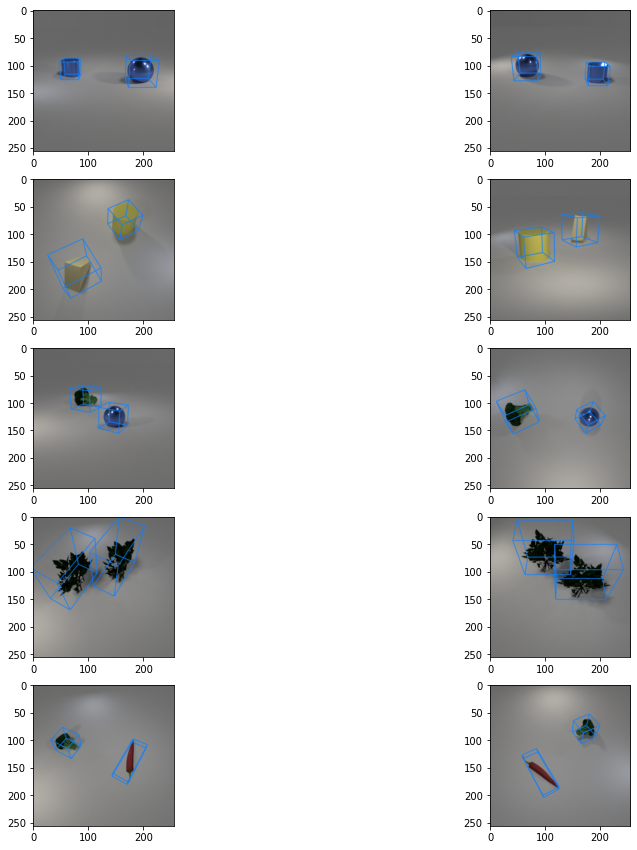

In [ ]:
f, axarr = plt.subplots(5,2, figsize=(15,15))
for row in range(5):
    axarr[row,0].imshow(feed_dict_q['images_with_boxes'][row].detach().cpu().permute(1,2,0))
    axarr[row,1].imshow(feed_dict_k['images_with_boxes'][row].detach().cpu().permute(1,2,0))

In [ ]:
feed_dict_q['images'].shape, feed_dict_q['objects'].shape, feed_dict_q['objects_boxes'].shape

(torch.Size([5, 3, 256, 256]), torch.Size([5]), torch.Size([10, 4]))

In [ ]:

feed_dict_q['objects']

tensor([2, 2, 2, 2, 2])

In [ ]:
feed_dict_q['objects_boxes'].shape

torch.Size([10, 4])

In [ ]:
metadata['pix_T_cams_raw'].shape

torch.Size([5, 2, 4, 4])

In [ ]:
metadata['camR_T_origin_raw'].shape

torch.Size([5, 2, 4, 4])

In [ ]:
metadata['origin_T_camXs_raw'].shape

torch.Size([5, 2, 4, 4])

In [ ]:
metadata['rel_viewpoint'].shape

torch.Size([5, 1, 7])

In [ ]:
def draw_bounding_box(image, bboxes):
    
    num_obj= bboxes.size(0)
    fig = plt.figure(figsize=(8,8*num_obj))
    
    axes = []
    for o in range(num_obj):
        ax = (fig.add_subplot(1,num_obj,o+1))
        axes.append(ax)
        box = bboxes[o]
        x1,y1,x2,y2 = box
        x1 = int(x1.item()); x2 = int(x2.item()); y1 = int(y1.item()); y2 = int(y2.item())
        ax.title.set_text("x1:{} , x2:{} , y1:{} , y2:{}".format(x1,x2,y1,y2))
        img = cv2.rectangle(image.copy(),(x1,y1),(x2,y2),(0,255,0),2)
        plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


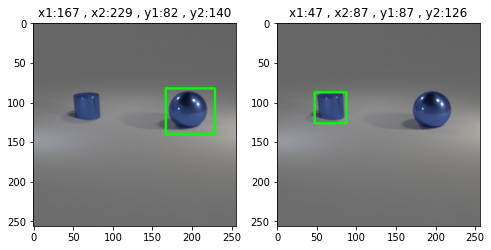

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


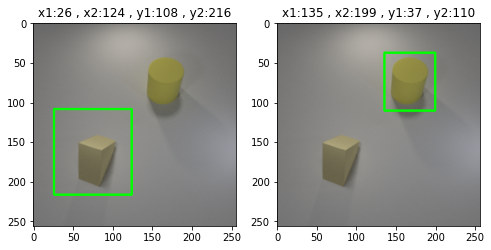

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


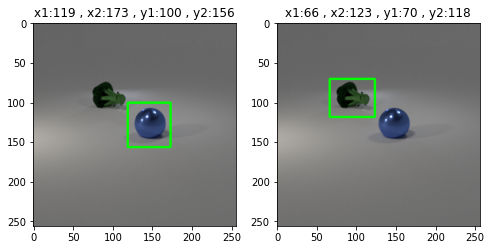

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


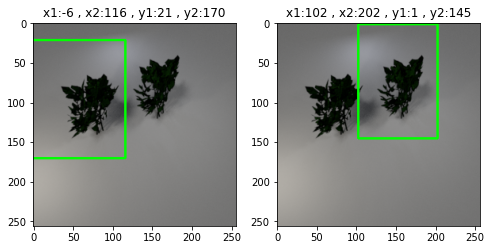

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


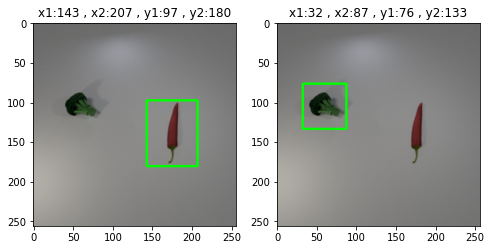

In [ ]:
for i in range(5):
    box = feed_dict_q['objects_boxes'][2*i: 2*i+2]
    
    draw_bounding_box(feed_dict_q['images'][i].permute(1,2,0).cpu().numpy(), box)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


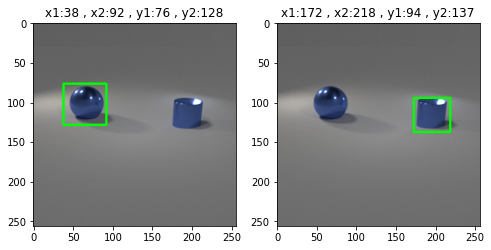

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


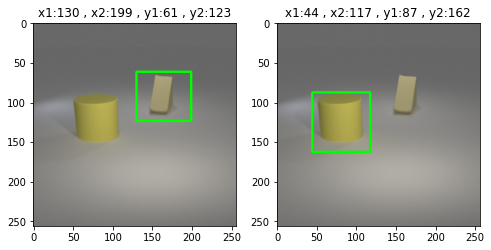

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


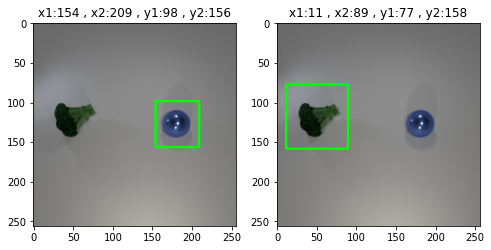

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


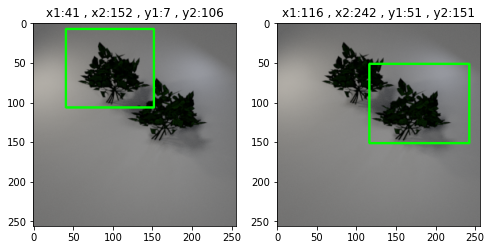

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


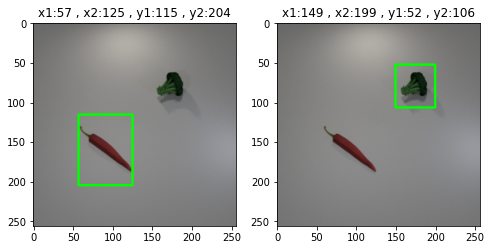

In [ ]:
for i in range(5):
    box = feed_dict_k['objects_boxes'][2*i: 2*i+2]
    
    draw_bounding_box(feed_dict_k['images'][i].permute(1,2,0).cpu().numpy(), box)
    plt.show()

In [ ]:
def collate_boxes_onlyquery(data):
    query_image, num_boxes_q, boxes_q, boxes_viz_q, scene_num, query_img_view, pix_T_cams_raw, camR_T_origin_raw, idx, scene_path = zip(*data)
    batch_size = len(num_boxes_q)
    
#     print(torch.stack(list(query_image)))
    query_image = torch.stack(list(query_image))
    
    num_boxes_q = torch.as_tensor(list(num_boxes_q))
    
    boxes_q = list(boxes_q)
    
    boxes_viz_q = torch.stack(list(boxes_viz_q))
 
    object_boxes_q = torch.cat(boxes_q, dim=0)
    
    scene_num = torch.as_tensor(list(scene_num))
    query_img_view = torch.as_tensor(list(query_img_view))
    idx = torch.as_tensor(list(idx))
    scene_path = list(scene_path)
    
    pix_T_cams_raw = torch.stack(list(pix_T_cams_raw), dim=0)
    camR_T_origin_raw = torch.stack(list(camR_T_origin_raw), dim=0)
    
    
    metadata = {"index":idx, "query_image_index":query_img_view ,"scene_number":scene_num, "pix_T_cams_raw":torch.as_tensor(pix_T_cams_raw).cuda(), "camR_T_origin_raw":torch.as_tensor(camR_T_origin_raw).cuda(), "scene_path":scene_path}
    feed_dict_q = {"images":torch.as_tensor(query_image).cuda(), "objects":num_boxes_q, "objects_boxes":torch.as_tensor(object_boxes_q).cuda(), "images_with_boxes": boxes_viz_q}
    
    return feed_dict_q, metadata


In [ ]:
class CLEVR_train_onlyquery(Dataset):
	def __init__(self, root_dir, hyp_N=1, transform=None, target_transform=None, few_shot=False):
		self.root_dir = root_dir
		self.transform = transform
		self.target_transform = target_transform
		self.target_res = 256
		self.N = hyp_N
		self.few_shot = few_shot
		self.views = 18


		if root_dir.endswith("txt"):
			data  = []

			with open(root_dir) as f:
				lines = f.readlines()

				for line in lines:
					data.append(line.split()[0])

			self.all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]
		else:
			self.all_files = [os.path.join(root_dir,f) for f in os.listdir(root_dir) if f.endswith('.p')]
			
		self.all_files.sort()
			
		print('Initialised.....',len(self.all_files)*self.views,' files...')
			
 
		self.do_shape = True
		self.do_color = False
		self.do_material = False
		self.do_style = False
		self.do_style_content = False

	def trees_rearrange(self, trees):
		updated_trees =[]
		all_bboxes = []
		all_scores = []
		all_classes_list = []
		for tree in trees:
			tree,boxes,_,all_classes = self.bbox_rearrange(tree,boxes=[],classes={},all_classes=[])
			if self.do_shape:
				classes = [class_val["shape"] for class_val  in all_classes]
			elif self.do_color:
				classes = [class_val["color"] for class_val  in all_classes]
			elif self.do_material:
				classes = [class_val["material"] for class_val  in all_classes]
			elif self.do_style:
				classes = [class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
			elif self.do_style_content:
				classes = [class_val["shape"]+"/"+class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
			elif self.do_color_content:            
				classes = [class_val["shape"]+"/"+class_val["color"] for class_val  in all_classes]
			elif self.do_material_content:            
				classes = [class_val["shape"]+"/"+ class_val["material"] for class_val  in all_classes]
			else:            
				classes = [class_val["shape"]+"/"+ class_val["color"] +"_"+class_val["material"] for class_val  in all_classes]
			boxes = np.stack(boxes)
			classes = np.stack(classes)
			n,_  = boxes.shape 
			assert n == len(classes)
			scores = np.pad(np.ones([n]),[0,self.N-n])
			boxes = np.pad(boxes,[[0,self.N-n],[0,0]])
			classes = np.pad(classes,[0,self.N-n])
			updated_trees.append(tree)
			all_classes_list.append(classes)
			all_scores.append(scores)
			all_bboxes.append(boxes)
		all_bboxes = np.stack(all_bboxes)
		all_scores = np.stack(all_scores)
		all_classes_list = np.stack(all_classes_list)
		return all_bboxes,all_scores,all_classes_list

	def bbox_rearrange(self, tree,boxes= [],classes={},all_classes=[]):
		for i in range(0, tree.num_children):
			updated_tree,boxes,classes,all_classes = self.bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
			tree.children[i] = updated_tree     
		if tree.function == "describe":
			xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
			box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
			tree.bbox_origin = box
			boxes.append(box)
			classes["shape"] = tree.word
			all_classes.append(classes)
			classes = {}
		if tree.function == "combine":
			if "large" in tree.word or "small" in tree.word:
				classes["size"] = tree.word
			elif "metal" in tree.word or "rubber" in tree.word:
				classes["material"] = tree.word
			else:
				classes["color"] = tree.word
		return tree,boxes,classes,all_classes

	def __len__(self):
		return len(self.all_files)*self.views

	def __getitem__(self, idx):
		
		hyp_B = 1
		hyp_S = 1
		hyp_N = self.N

		__p = lambda x: utils_disco.pack_seqdim(x, hyp_B)
		__u = lambda x: utils_disco.unpack_seqdim(x, hyp_B)
		__pb = lambda x: utils_disco.pack_boxdim(x, hyp_N)
		__ub = lambda x: utils_disco.unpack_boxdim(x, hyp_N)
		
		Z, Y, X = 144, 144, 144
		Z2, Y2, X2 = int(Z/2), int(Y/2), int(X/2)
		Z4, Y4, X4 = int(Z/4), int(Y/4), int(X/4)
		
		######## Get query and key index #########################
		
		scene_num = idx // self.views
        
		query_idx = idx % self.views
		

		scene_path = self.all_files[scene_num]
		data = pickle.load(open(scene_path, "rb"))
		
		###### Take necessary matrices from data dict ############
		
		tids = torch.from_numpy(np.reshape(np.arange(hyp_B*hyp_N),[hyp_B,hyp_N]))
		pix_T_cams = torch.from_numpy(data["pix_T_cams_raw"][query_idx]).reshape(hyp_B, hyp_S, 4, 4).cuda()
		
		camRs_T_origin = data['camR_T_origin_raw'][query_idx]
		camRs_T_origin = torch.from_numpy(camRs_T_origin).reshape(hyp_B, hyp_S, 4, 4).cuda()
		
		origin_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_origin)))
		
		origin_T_camXs = torch.from_numpy(data['origin_T_camXs_raw'][query_idx]).reshape(hyp_B, hyp_S, 4, 4).cuda()
		camX0_T_camXs = utils_disco.get_camM_T_camXs(origin_T_camXs, ind=0)
		camRs_T_camXs = __u(torch.matmul(utils_disco.safe_inverse(__p(origin_T_camRs)), __p(origin_T_camXs))) 


		camXs_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_camXs)))
		camX0_T_camRs = camXs_T_camRs[:,0]
		
		camR_T_camX0  = utils_disco.safe_inverse(camX0_T_camRs)
										  
		rgb_camXs = data["rgb_camXs_raw"][:,:,:,:3]
		rgb_camX0 = torch.from_numpy(rgb_camXs[query_idx]).permute(2,0,1).reshape(hyp_B, 3, 256, 256) #torch.from_numpy(np.fliplr(rgb_camXs[0,0])).reshape(1, 256, 256, 3).permute(0,3,1,2)
                                
										  
		############ load tree file ##############################
		
		tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
		tree_path = tree_path.replace("datasets","dataset")
		tree_file = pickle.load(open(os.path.join(tree_path),"rb"))
										  
		gt_boxesR,scores,classes = self.trees_rearrange([tree_file])
		
		########### set up gt boxes #############################
										  
		gt_boxesR = torch.from_numpy(gt_boxesR).cuda().float() # torch.Size([2, 3, 6])
		gt_boxesR_end = torch.reshape(gt_boxesR,[hyp_B,hyp_N,2,3])
		gt_boxesR_theta = utils_disco.get_alignedboxes2thetaformat(gt_boxesR_end)
		gt_boxesR_corners = utils_disco.transform_boxes_to_corners(gt_boxesR_theta)
										  
		gt_boxesRMem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z2,Y2,X2))
		gt_boxesRMem_end = utils_disco.get_ends_of_corner(gt_boxesRMem_corners) 
		
		gt_boxesRMem_theta = utils_disco.transform_corners_to_boxes(gt_boxesRMem_corners)
		gt_boxesRUnp_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z,Y,X))
										  
		gt_boxesRUnp_end = utils_disco.get_ends_of_corner(gt_boxesRUnp_corners)
										  
		gt_boxesX0_corners = __ub(utils_disco.apply_4x4(camX0_T_camRs, __pb(gt_boxesR_corners)))

										  
		gt_boxesXs_corners = __u(__ub(utils_disco.apply_4x4(__p(camXs_T_camRs), __p(__pb(gt_boxesR_corners).unsqueeze(1).repeat(1,hyp_S,1,1)) )))
		gt_boxesXs_end = __u(utils_disco.get_ends_of_corner(__p(gt_boxesXs_corners)))
										  
		gt_boxesX0Mem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesX0_corners),Z2,Y2,X2))
		gt_boxesX0Mem_theta = utils_disco.transform_corners_to_boxes(gt_boxesX0Mem_corners)
		gt_boxesX0Mem_end = utils_disco.get_ends_of_corner(gt_boxesX0Mem_corners)
		gt_boxesX0_end = utils_disco.get_ends_of_corner(gt_boxesX0_corners)  
										  
		gt_cornersX0_pix = __ub(utils_disco.apply_pix_T_cam(pix_T_cams[:,0], __pb(gt_boxesX0_corners)))

										  
		########### gt egomotion #############################################

		################# get bbobex on image    ##############################
		boxes_vis_q, corners_pix_q = summ_box_by_corners(rgb_camX0, gt_boxesX0_corners, torch.from_numpy(scores), tids, pix_T_cams[:, 0])

		boxes_q = torch.zeros([hyp_N, 4])

		for n in range(hyp_N):
			boxes_q[n][0] = torch.min(corners_pix_q[0, n, :, 0]) 
			boxes_q[n][1] = torch.min(corners_pix_q[0, n, :, 1]) 
			boxes_q[n][2] = torch.max(corners_pix_q[0, n, :, 0]) 
			boxes_q[n][3] = torch.max(corners_pix_q[0, n, :, 1])


            
		return (rgb_camX0/255.).squeeze(), hyp_N, boxes_q, boxes_vis_q.squeeze(), scene_num, query_idx, pix_T_cams.squeeze(), origin_T_camXs.squeeze(), idx, scene_path


In [ ]:
train_dataset_kmeans = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5t.txt', hyp_N=1)

Initialised..... 4500  files...


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_kmeans, batch_size=5, shuffle=True, collate_fn=collate_boxes_onlyquery)

In [ ]:
for b in train_loader:
    feed_dict_q, metadata = b
    break

../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [ ]:
metadata['scene_number'], metadata['query_image_index'], metadata['index']

(tensor([ 35, 225,  32, 153, 130]),
 tensor([13,  2, 15, 11,  4]),
 tensor([ 643, 4052,  591, 2765, 2344]))

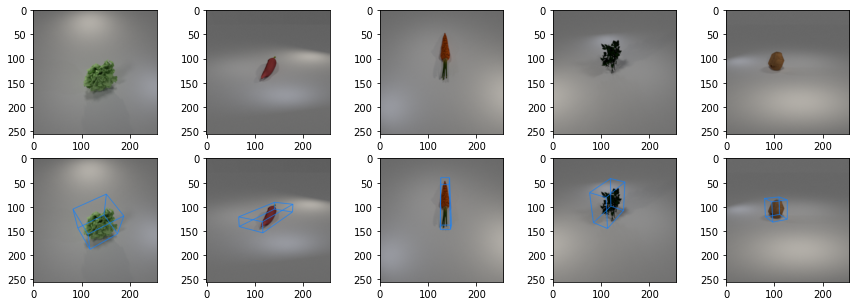

In [ ]:
f, axarr = plt.subplots(2,5, figsize=(15,5))
for row in range(5):
    axarr[0][row].imshow(feed_dict_q['images'][row].detach().cpu().permute(1,2,0))
    axarr[1][row].imshow(feed_dict_q['images_with_boxes'][row].detach().cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


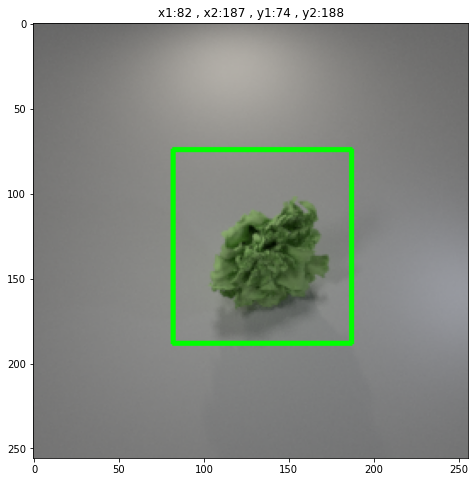

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


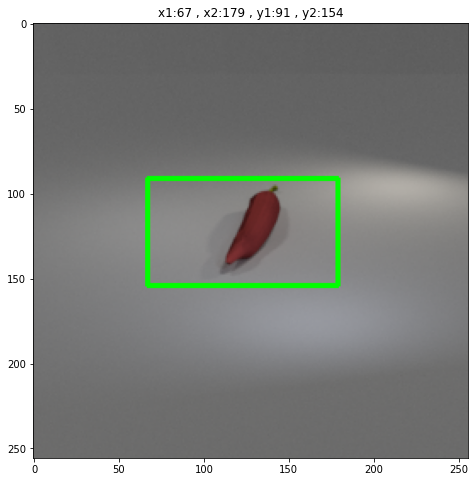

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


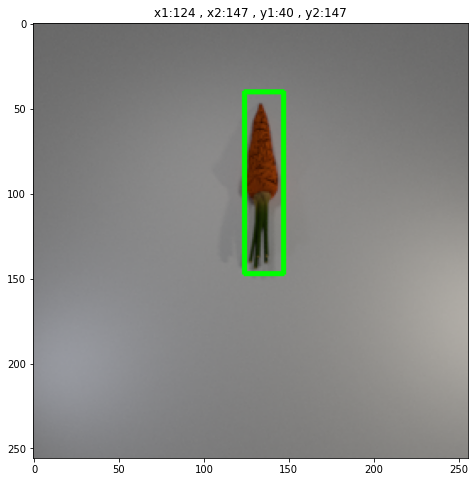

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


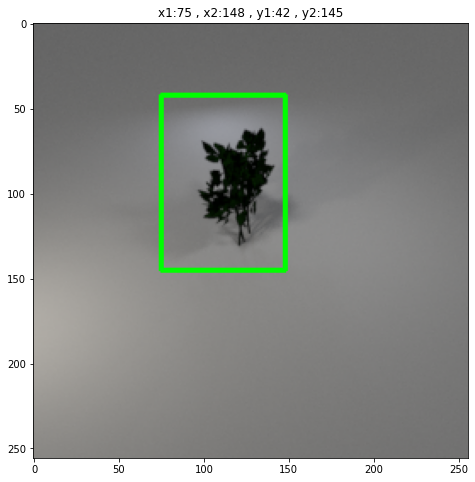

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


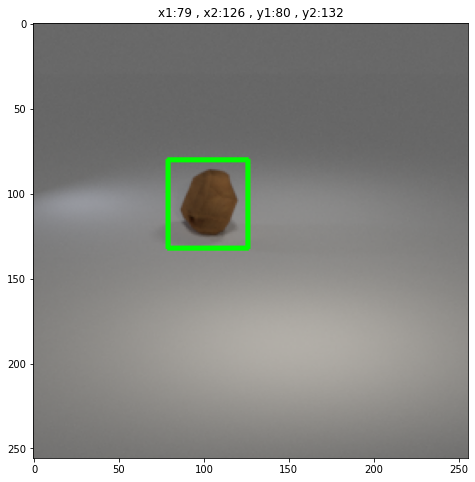

In [ ]:
for i in range(5):
    box = feed_dict_q['objects_boxes'][i:i+1]
    
    draw_bounding_box(feed_dict_q['images'][i].permute(1,2,0).cpu().numpy(), box)
    plt.show()

In [ ]:
feed_dict_q['images'].shape, feed_dict_q['objects'].shape, feed_dict_q['objects_boxes'].shape

(torch.Size([5, 3, 256, 256]), torch.Size([5]), torch.Size([5, 4]))

In [ ]:
metadata['pix_T_cams_raw'].shape

torch.Size([5, 4, 4])

In [ ]:
train_dataset_kmeans = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)

Initialised..... 4212  files...


In [ ]:
train_loader = DataLoader(train_dataset_kmeans, batch_size=5, shuffle=True, collate_fn=collate_boxes_onlyquery)

In [ ]:
for b in train_loader:
    feed_dict_q, metadata = b
    break

../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


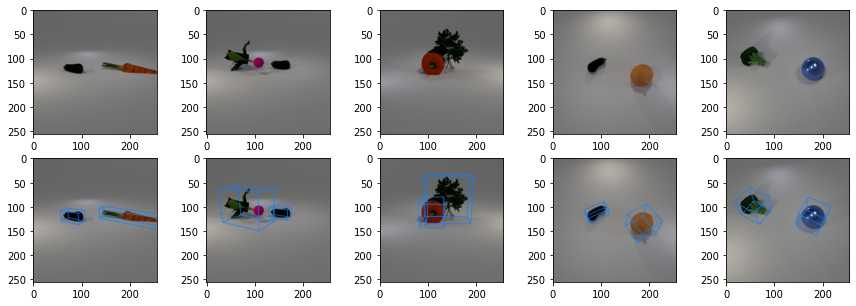

In [ ]:
f, axarr = plt.subplots(2,5, figsize=(15,5))
for row in range(5):
    axarr[0][row].imshow(feed_dict_q['images'][row].detach().cpu().permute(1,2,0))
    axarr[1][row].imshow(feed_dict_q['images_with_boxes'][row].detach().cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


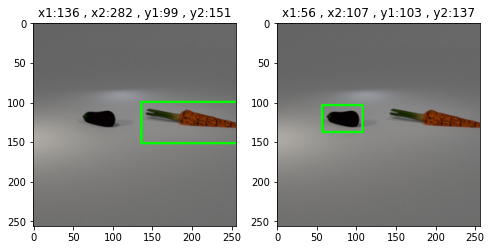

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


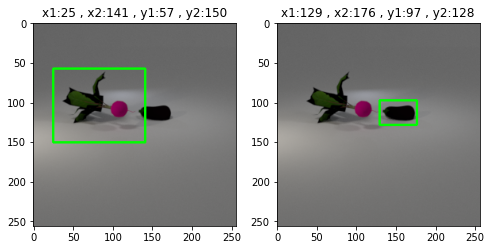

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


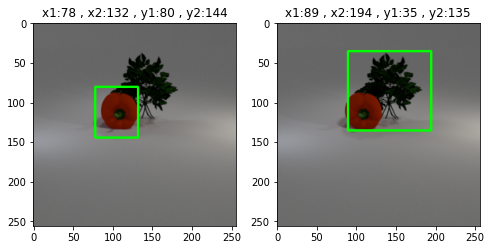

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


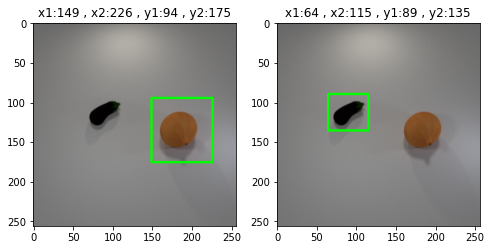

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


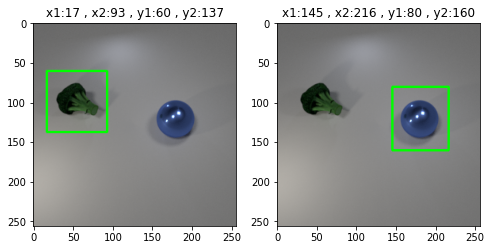

In [ ]:
for i in range(5):
    box = feed_dict_q['objects_boxes'][2*i:2*i+2]
    
    draw_bounding_box(feed_dict_q['images'][i].permute(1,2,0).cpu().numpy(), box)
    plt.show()

In [ ]:
class CLEVR_train_sampleallnegs(Dataset):
	def __init__(self, scene_path, hyp_N=1, transform=None, target_transform=None, few_shot=False, scene_num=0, query_num=0, key_num=1):
		self.scene_path = scene_path

		self.target_res = 256
		self.N = hyp_N

		self.views = 18
		self.query_num = query_num
		self.key_num = key_num
		self.scene_num = scene_num
 
		self.do_shape = True
		self.do_color = False
		self.do_material = False
		self.do_style = False
		self.do_style_content = False

	def trees_rearrange(self, trees):
		updated_trees =[]
		all_bboxes = []
		all_scores = []
		all_classes_list = []
		for tree in trees:
			tree,boxes,_,all_classes = self.bbox_rearrange(tree,boxes=[],classes={},all_classes=[])
			if self.do_shape:
				classes = [class_val["shape"] for class_val  in all_classes]
			elif self.do_color:
				classes = [class_val["color"] for class_val  in all_classes]
			elif self.do_material:
				classes = [class_val["material"] for class_val  in all_classes]
			elif self.do_style:
				classes = [class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
			elif self.do_style_content:
				classes = [class_val["shape"]+"/"+class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
			elif self.do_color_content:            
				classes = [class_val["shape"]+"/"+class_val["color"] for class_val  in all_classes]
			elif self.do_material_content:            
				classes = [class_val["shape"]+"/"+ class_val["material"] for class_val  in all_classes]
			else:            
				classes = [class_val["shape"]+"/"+ class_val["color"] +"_"+class_val["material"] for class_val  in all_classes]
			boxes = np.stack(boxes)
			classes = np.stack(classes)
			n,_  = boxes.shape 
			assert n == len(classes)
			scores = np.pad(np.ones([n]),[0,self.N-n])
			boxes = np.pad(boxes,[[0,self.N-n],[0,0]])
			classes = np.pad(classes,[0,self.N-n])
			updated_trees.append(tree)
			all_classes_list.append(classes)
			all_scores.append(scores)
			all_bboxes.append(boxes)
		all_bboxes = np.stack(all_bboxes)
		all_scores = np.stack(all_scores)
		all_classes_list = np.stack(all_classes_list)
		return all_bboxes,all_scores,all_classes_list

	def bbox_rearrange(self, tree,boxes= [],classes={},all_classes=[]):
		for i in range(0, tree.num_children):
			updated_tree,boxes,classes,all_classes = self.bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
			tree.children[i] = updated_tree     
		if tree.function == "describe":
			xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
			box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
			tree.bbox_origin = box
			boxes.append(box)
			classes["shape"] = tree.word
			all_classes.append(classes)
			classes = {}
		if tree.function == "combine":
			if "large" in tree.word or "small" in tree.word:
				classes["size"] = tree.word
			elif "metal" in tree.word or "rubber" in tree.word:
				classes["material"] = tree.word
			else:
				classes["color"] = tree.word
		return tree,boxes,classes,all_classes

	def __len__(self):
		return self.views

	def __getitem__(self, idx):
		
		hyp_B = 1
		hyp_S = 1
		hyp_N = self.N

		__p = lambda x: utils_disco.pack_seqdim(x, hyp_B)
		__u = lambda x: utils_disco.unpack_seqdim(x, hyp_B)
		__pb = lambda x: utils_disco.pack_boxdim(x, hyp_N)
		__ub = lambda x: utils_disco.unpack_boxdim(x, hyp_N)
		
		Z, Y, X = 144, 144, 144
		Z2, Y2, X2 = int(Z/2), int(Y/2), int(X/2)
		Z4, Y4, X4 = int(Z/4), int(Y/4), int(X/4)
		
		######## Get query and key index #########################
		
		scene_num = self.scene_num
		
		query_idx = idx
		

# 		scene_path = self.all_files[scene_num]
		data = pickle.load(open(self.scene_path, "rb"))
		
		###### Take necessary matrices from data dict ############
		
		tids = torch.from_numpy(np.reshape(np.arange(hyp_B*hyp_N),[hyp_B,hyp_N]))
		pix_T_cams = torch.from_numpy(data["pix_T_cams_raw"][query_idx]).reshape(hyp_B, hyp_S, 4, 4).cuda()
		
		camRs_T_origin = data['camR_T_origin_raw'][query_idx]
		camRs_T_origin = torch.from_numpy(camRs_T_origin).reshape(hyp_B, hyp_S, 4, 4).cuda()
		
		origin_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_origin)))
		
		origin_T_camXs = torch.from_numpy(data['origin_T_camXs_raw'][query_idx]).reshape(hyp_B, hyp_S, 4, 4).cuda()
		camX0_T_camXs = utils_disco.get_camM_T_camXs(origin_T_camXs, ind=0)
		camRs_T_camXs = __u(torch.matmul(utils_disco.safe_inverse(__p(origin_T_camRs)), __p(origin_T_camXs))) 


		camXs_T_camRs = __u(utils_disco.safe_inverse(__p(camRs_T_camXs)))
		camX0_T_camRs = camXs_T_camRs[:,0]
		
		camR_T_camX0  = utils_disco.safe_inverse(camX0_T_camRs)
										  
		rgb_camXs = data["rgb_camXs_raw"][:,:,:,:3]
		rgb_camX0 = torch.from_numpy(rgb_camXs[query_idx]).permute(2,0,1).reshape(hyp_B, 3, 256, 256) #torch.from_numpy(np.fliplr(rgb_camXs[0,0])).reshape(1, 256, 256, 3).permute(0,3,1,2)
								
										  
		############ load tree file ##############################
		
		tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
		tree_path = tree_path.replace("datasets","dataset")
		tree_file = pickle.load(open(os.path.join(tree_path),"rb"))
										  
		gt_boxesR,scores,classes = self.trees_rearrange([tree_file])
		
		########### set up gt boxes #############################
										  
		gt_boxesR = torch.from_numpy(gt_boxesR).cuda().float() # torch.Size([2, 3, 6])
		gt_boxesR_end = torch.reshape(gt_boxesR,[hyp_B,hyp_N,2,3])
		gt_boxesR_theta = utils_disco.get_alignedboxes2thetaformat(gt_boxesR_end)
		gt_boxesR_corners = utils_disco.transform_boxes_to_corners(gt_boxesR_theta)
										  
		gt_boxesRMem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z2,Y2,X2))
		gt_boxesRMem_end = utils_disco.get_ends_of_corner(gt_boxesRMem_corners) 
		
		gt_boxesRMem_theta = utils_disco.transform_corners_to_boxes(gt_boxesRMem_corners)
		gt_boxesRUnp_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesR_corners),Z,Y,X))
										  
		gt_boxesRUnp_end = utils_disco.get_ends_of_corner(gt_boxesRUnp_corners)
										  
		gt_boxesX0_corners = __ub(utils_disco.apply_4x4(camX0_T_camRs, __pb(gt_boxesR_corners)))

										  
		gt_boxesXs_corners = __u(__ub(utils_disco.apply_4x4(__p(camXs_T_camRs), __p(__pb(gt_boxesR_corners).unsqueeze(1).repeat(1,hyp_S,1,1)) )))
		gt_boxesXs_end = __u(utils_disco.get_ends_of_corner(__p(gt_boxesXs_corners)))
										  
		gt_boxesX0Mem_corners = __ub(utils_vox.Ref2Mem(__pb(gt_boxesX0_corners),Z2,Y2,X2))
		gt_boxesX0Mem_theta = utils_disco.transform_corners_to_boxes(gt_boxesX0Mem_corners)
		gt_boxesX0Mem_end = utils_disco.get_ends_of_corner(gt_boxesX0Mem_corners)
		gt_boxesX0_end = utils_disco.get_ends_of_corner(gt_boxesX0_corners)  
										  
		gt_cornersX0_pix = __ub(utils_disco.apply_pix_T_cam(pix_T_cams[:,0], __pb(gt_boxesX0_corners)))

										  
		########### gt egomotion #############################################

		################# get bbobex on image    ##############################
		boxes_vis_q, corners_pix_q = summ_box_by_corners(rgb_camX0, gt_boxesX0_corners, torch.from_numpy(scores), tids, pix_T_cams[:, 0])

		boxes_q = torch.zeros([hyp_N, 4])

		for n in range(hyp_N):
			boxes_q[n][0] = torch.min(corners_pix_q[0, n, :, 0]) 
			boxes_q[n][1] = torch.min(corners_pix_q[0, n, :, 1]) 
			boxes_q[n][2] = torch.max(corners_pix_q[0, n, :, 0]) 
			boxes_q[n][3] = torch.max(corners_pix_q[0, n, :, 1])


			
		return (rgb_camX0/255.).squeeze(), hyp_N, boxes_q, boxes_vis_q.squeeze(), scene_num, query_idx, pix_T_cams.squeeze(), origin_T_camXs.squeeze(), idx, self.scene_path

	

In [ ]:
def sample_same_scene_negs(feed_dict_q, feed_dict_k, metadata, hyp_N, views_to_sample = 16):
    assert views_to_sample <= 16
    
    B = feed_dict_q['images'].shape[0]
    
    full_list = []
    
    for b in range(B):
        scene_path = metadata['scene_path'][b]
        q_idx = metadata["query_image_index"][b]
        k_idx = metadata["key_image_index"][b]
        scene_num = metadata["scene_number"][b]

        neg_dataset = CLEVR_train_sampleallnegs(scene_path, hyp_N=hyp_N, scene_num=scene_num, query_num=q_idx, key_num=k_idx)
        neg_loader = DataLoader(neg_dataset, batch_size=1, shuffle=True, collate_fn=collate_boxes_onlyquery)

        feed_dict_n_list = []
        views_fetched = 1

        for i in neg_loader:
            if views_fetched>views_to_sample:
                break

            feed_dict_n, m = i
            if (m['index'] == q_idx) or (m['index'] == k_idx):
                continue
            feed_dict_n_list.append(feed_dict_n)
            
        full_list.append(feed_dict_n_list)
    return full_list #feed_dict_n_list
        
    
    

In [ ]:
args = {'hyp_N':2}
feed_dict_n_list = sample_same_scene_negs(feed_dict_q, feed_dict_k, metadata, 2)

../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [ ]:
len(feed_dict_n_list), len(feed_dict_n_list[0])

(5, 16)

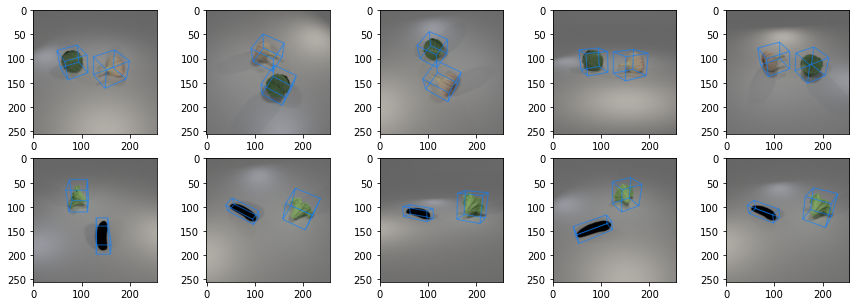

In [ ]:
f, axarr = plt.subplots(2,5, figsize=(15,5))
for row in range(5):
    axarr[0][row].imshow(feed_dict_n_list[0][row]['images_with_boxes'].squeeze().detach().cpu().permute(1,2,0))
    axarr[1][row].imshow(feed_dict_n_list[1][row]['images_with_boxes'].squeeze().detach().cpu().permute(1,2,0))